In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

import warnings
warnings.filterwarnings('ignore')

Реализуем генерацию  𝑁
  бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [2]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [3]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_criterion, criterion):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini, gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [12]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [15]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

__Задание 1__ Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.

Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

In [16]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [18]:
classification_data, classification_labels = make_classification(n_samples=100,
                                                                          n_features=2, n_informative=1, 
                                                                          n_classes=2, n_redundant=0, 
                                                                          n_clusters_per_class=1,
                                                                          random_state=42)

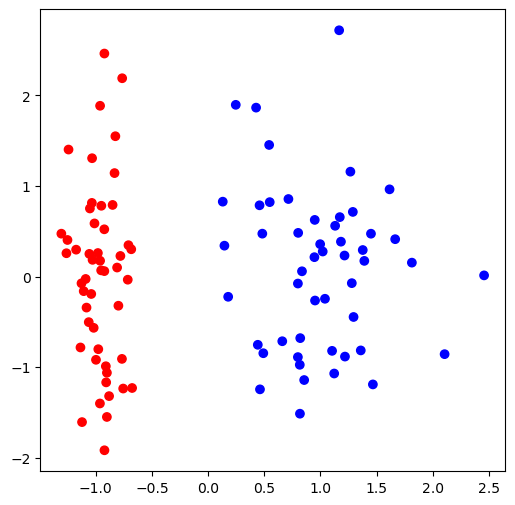

In [20]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [21]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                    classification_labels, 
                                                                                    test_size=0.3,
                                                                                    random_state=42)

Точность случайного леса из 1 деревьев на train: 90.000
Точность случайного леса из 1 деревьев на test: 73.333
CPU times: total: 156 ms
Wall time: 134 ms


Text(0.5, 1.0, 'Test accuracy=73.33')

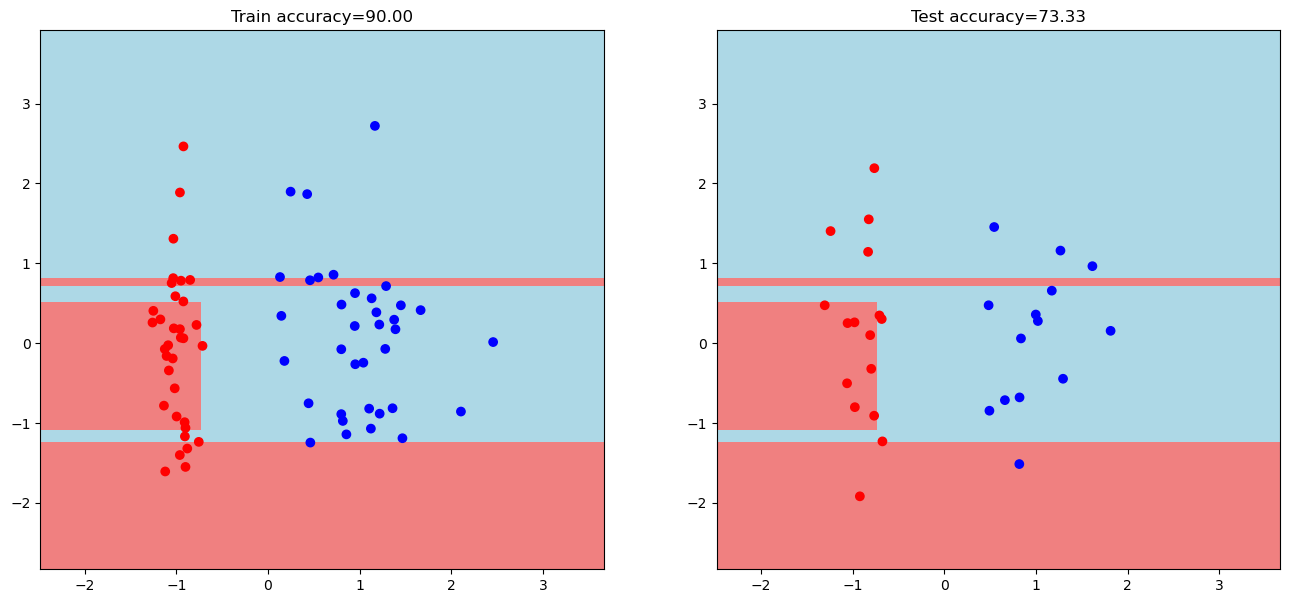

In [22]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

train_answs = tree_vote(my_forest_1, train_data)
test_answs = tree_vote(my_forest_1, test_data)

train_acc = accuracy_metric(train_labels, train_answs)
test_acc = accuracy_metric(test_labels, test_answs)

print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

Точность случайного леса из 3 деревьев на train: 98.571
Точность случайного леса из 3 деревьев на test: 80.000
CPU times: total: 203 ms
Wall time: 199 ms


Text(0.5, 1.0, 'Test accuracy=80.00')

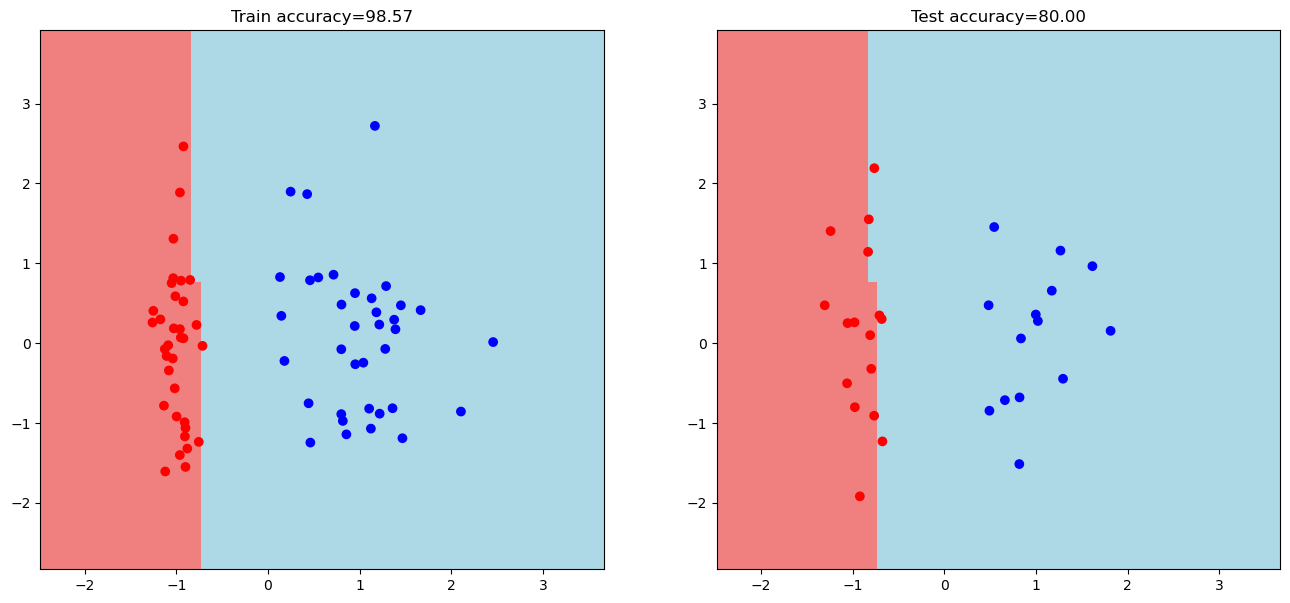

In [23]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

train_answs = tree_vote(my_forest_3, train_data)
test_answs = tree_vote(my_forest_3, test_data)

train_acc = accuracy_metric(train_labels, train_answs)
test_acc = accuracy_metric(test_labels, test_answs)

print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

Точность случайного леса из 10 деревьев на train: 100.000
Точность случайного леса из 10 деревьев на test: 90.000
CPU times: total: 469 ms
Wall time: 458 ms


Text(0.5, 1.0, 'Test accuracy=90.00')

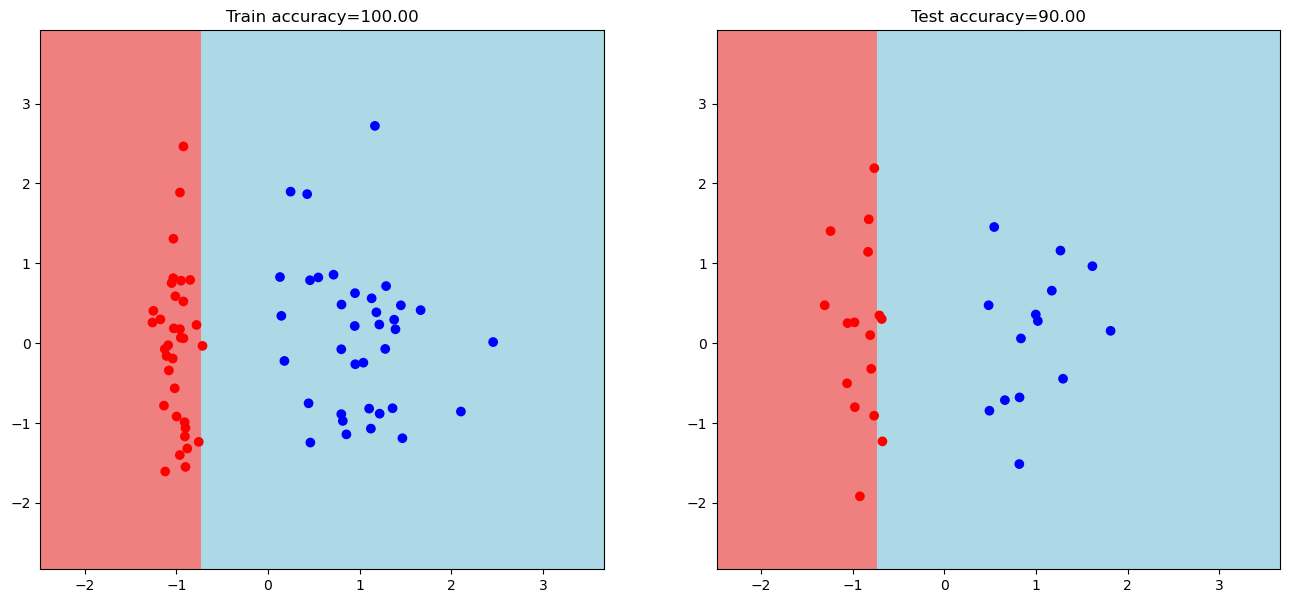

In [24]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

train_answs = tree_vote(my_forest_10, train_data)
test_answs = tree_vote(my_forest_10, test_data)

train_acc = accuracy_metric(train_labels, train_answs)
test_acc = accuracy_metric(test_labels, test_answs)

print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

Точность случайного леса из 50 деревьев на train: 100.000
Точность случайного леса из 50 деревьев на test: 90.000
CPU times: total: 1.64 s
Wall time: 1.64 s


Text(0.5, 1.0, 'Test accuracy=90.00')

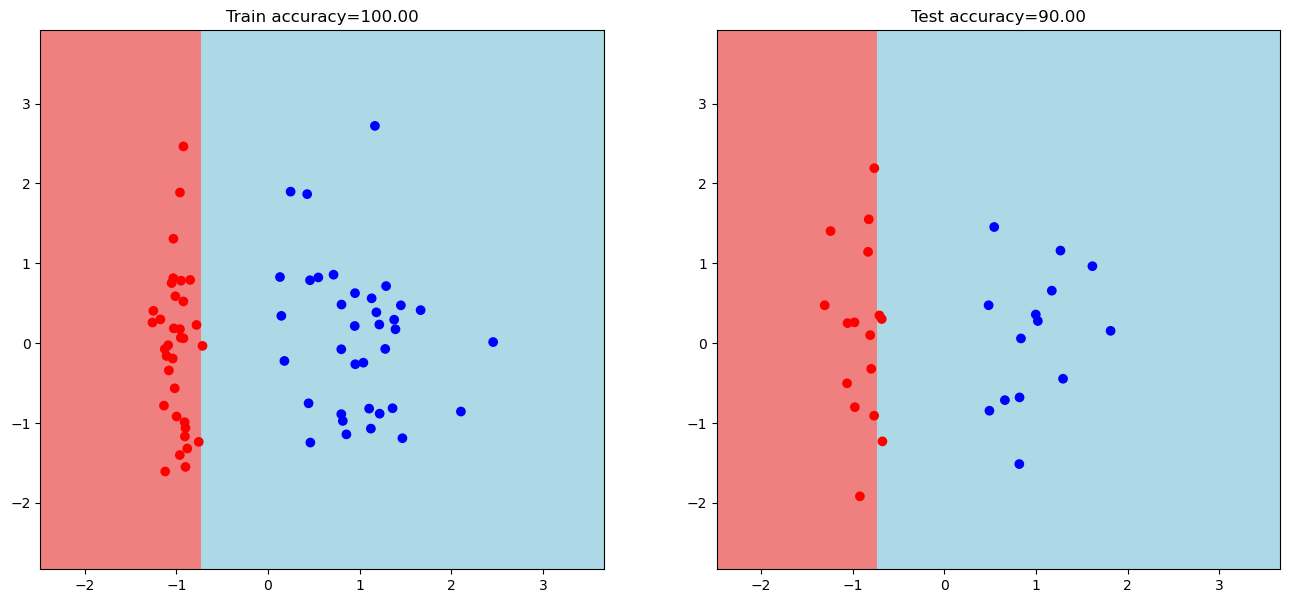

In [25]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

train_answs = tree_vote(my_forest_50, train_data)
test_answs = tree_vote(my_forest_50, test_data)

train_acc = accuracy_metric(train_labels, train_answs)
test_acc = accuracy_metric(test_labels, test_answs)

print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

От количества деревьев зависит сложность гиперплоскости. Чем больше деревьев, тем сложнее гиперплоскость


__Задание 2__ Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.

In [26]:
10 obj, 5 trees
0 - 1 -> 0, 2 -> 0  -> 0  0
1 - 0 -> 1, 1 -> 0  -> 0  1
2 - 4 -> 0, 5 -> 0  -> 0  0
3 - 1 -> 0
4 - 
5
6
7
8
9

SyntaxError: invalid syntax (2920336862.py, line 1)

In [27]:
np.random.seed(42)

def get_oob_indices(sample_indices):
    indices = np.arange(len(sample_indices))
    return indices[~np.isin(indices, sample_indices)]


def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap_oob = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        oob_indices = get_oob_indices(sample_index)
        
        bootstrap_oob.append((b_data, b_labels, oob_indices))        
        
    return bootstrap_oob

In [28]:
b = get_bootstrap(train_data, train_labels, 1)
b[0][2].shape[0] * 100 / b[0][0].shape[0]

41.42857142857143

In [29]:
np.zeros((10, len(set(classification_labels))))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [30]:
def predict_oob(oob_predictions, oob_indices, tree, data):
    oob_data = data[oob_indices]
    prediction = predict(oob_data, tree)
    
    for i in range(len(oob_indices)):
        oob_predictions[oob_indices[i], prediction[i]] += 1
    return oob_predictions

    
def random_forest_oob(data, labels, n_trees):
    forest = []
    oob_predictions = np.zeros((data.shape[0], len(set(labels))))
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels, oob_indices in bootstrap:
        tree = build_tree(b_data, b_labels)
        forest.append(tree)
        
        oob_predictions = predict_oob(oob_predictions=oob_predictions,
                                      oob_indices=oob_indices,
                                      tree=tree,
                                      data=data)
#     print(oob_predictions)
    oob_score = accuracy_metric(labels, np.argmax(oob_predictions, axis=1))
    
    return forest, oob_score

In [31]:
forest, oob_score = random_forest_oob(classification_data, classification_labels, 5)
oob_score

91.0

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True, n_estimators=5)
rf.fit(classification_data, classification_labels)
rf.oob_score_

0.94